In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING logs
import warnings
# Suppress the specific warning
warnings.filterwarnings('ignore', category=RuntimeWarning)
print("Done")

Done


1.1 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
print("Done")

2025-04-14 16:03:56.662450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744646636.878808      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744646636.944887      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


1.2 Load Datasets

In [3]:
import pandas as pd

# Load datasets with encoding handling
climate_df = pd.read_csv('/kaggle/input/crop-water-requirement-prediction-using-ml/Climate_Data.csv')
crop_df = pd.read_csv('/kaggle/input/crop-water-requirement-prediction-using-ml/Crop_Calender.csv', encoding='ISO-8859-1')
soil_class_df = pd.read_csv('/kaggle/input/crop-water-requirement-prediction-using-ml/Soil_Classification.csv')
soil_moisture_df = pd.read_csv('/kaggle/input/crop-water-requirement-prediction-using-ml/Soil_Moisture.csv')

# Quick check of the loaded data
print("✅ Climate Data shape:", climate_df.shape)
print("✅ Crop Calendar shape:", crop_df.shape)
print("✅ Soil Classification shape:", soil_class_df.shape)
print("✅ Soil Moisture shape:", soil_moisture_df.shape)
print("Done")


✅ Climate Data shape: (2557, 11)
✅ Crop Calendar shape: (25, 14)
✅ Soil Classification shape: (4, 8)
✅ Soil Moisture shape: (2205, 9)
Done


1..3 Preprocess Climate Data

In [4]:
# Step 1: Convert 'datetime' to proper datetime format
climate_processed_df = climate_df.copy()
climate_processed_df['datetime'] = pd.to_datetime(climate_processed_df['datetime'])

# Step 2: Sort the data by datetime
climate_processed_df = climate_processed_df.sort_values('datetime')

# Step 3: Keep only relevant columns and rename them
climate_processed_df = climate_processed_df[['datetime', 'T2M', 'RH2M', 'PRECTOTCORR']].rename(columns={
    'T2M': 'air_temp',
    'RH2M': 'air_humidity',
    'PRECTOTCORR': 'rainfall'
})

# Step 4: Verify the result
print(climate_processed_df.head())

    datetime  air_temp  air_humidity  rainfall
0 2018-01-01     17.92         24.23       0.0
1 2018-01-02     18.24         28.32       0.0
2 2018-01-03     19.31         28.21       0.0
3 2018-01-04     19.20         33.37       0.0
4 2018-01-05     19.91         62.90       0.0


1.4 Preprocess Soil Moisture Data

In [5]:
import pandas as pd

# STEP 1: Convert Year, Month, Date columns to a proper datetime column 'dt'
soil_moisture_df['dt'] = pd.to_datetime(
    soil_moisture_df[['Year', 'Month', 'Date']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

# STEP 2: Drop rows where datetime conversion failed
soil_moisture_df = soil_moisture_df.dropna(subset=['dt'])

# STEP 3: Drop duplicate datetime entries (keep the first one)
soil_moisture_df = soil_moisture_df.drop_duplicates(subset='dt', keep='first')

# STEP 4: Set 'dt' as the index — this is CRUCIAL for resampling
soil_moisture_df = soil_moisture_df.set_index('dt')

# STEP 5: Select only numeric columns (like soil_moisture) to resample
numeric_cols = soil_moisture_df.select_dtypes(include='number').columns

# STEP 6: Resample daily and interpolate
final_df = (
    soil_moisture_df[numeric_cols]
    .resample('D')
    .interpolate()
    .reset_index()
)

# Final preview
print(final_df.head())

          dt  Date  Month    Year  Avg_smlvl_at15cm  Unnamed: 7
0 2018-07-24  24.0    7.0  2018.0         28.157946         NaN
1 2018-07-25  25.0    7.0  2018.0         27.293970         NaN
2 2018-07-26  26.0    7.0  2018.0         26.345704         NaN
3 2018-07-27  27.0    7.0  2018.0         25.296293         NaN
4 2018-07-28  28.0    7.0  2018.0         24.315067         NaN


1.5 Merge All Data

In [6]:
# 1. Filter climate data to only August 2018 onwards
climate_aug2018_onwards = climate_processed_df[
    climate_processed_df['datetime'] >= '2018-08-01'
].copy()

# 2. Merge with soil moisture data
merged_df = pd.merge(
    climate_aug2018_onwards,
    final_df[['dt', 'Avg_smlvl_at15cm']],  # <- Corrected here
    left_on='datetime',
    right_on='dt',
    how='left'
).drop(columns=['dt'])

# 3. Verify no missing values in critical columns
print("\nData Quality Check:")
print(f"Rows with missing soil moisture: {merged_df['Avg_smlvl_at15cm'].isna().sum()}")
print(f"Date range: {merged_df['datetime'].min()} to {merged_df['datetime'].max()}")

# 4. Save with your requested filename
output_filename = 'climate_soil_moisture_merge.csv'
merged_df.to_csv(output_filename, index=False)

# 5. Show final confirmation
print("\nFirst 5 Rows of Merged Data:")
print(merged_df.head().to_string(index=False))
print(f"\n✅ Successfully saved to '{output_filename}'")


Data Quality Check:
Rows with missing soil moisture: 80
Date range: 2018-08-01 00:00:00 to 2024-12-31 00:00:00

First 5 Rows of Merged Data:
  datetime  air_temp  air_humidity  rainfall  Avg_smlvl_at15cm
2018-08-01     28.70         75.81      0.00         21.785613
2018-08-02     28.51         76.74      0.07         20.952706
2018-08-03     27.74         80.02      0.05         20.005092
2018-08-04     28.14         76.26      0.01         19.051896
2018-08-05     28.31         75.14      0.00         18.199130

✅ Successfully saved to 'climate_soil_moisture_merge.csv'


1.6 Normalize Data (Critical for LSTM)

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling to the numerical columns (using current column names)
scaled_data = scaler.fit_transform(merged_df[['air_temp', 'air_humidity', 'rainfall', 'Avg_smlvl_at15cm']])

# Create a new dataframe with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=['air_temp_scaled', 'air_humidity_scaled', 
                                              'rainfall_scaled', 'soil_moisture_scaled'])

# Keep the original columns and datetime
scaled_df = pd.concat([
    merged_df[['datetime', 'air_temp', 'air_humidity', 'rainfall', 'Avg_smlvl_at15cm']],
    scaled_df
], axis=1)

# Check the scaled dataframe
print("\nFirst 5 Rows of Scaled Data:")
print(scaled_df.head().to_string(index=False))

# Save the scaled data
scaled_df.to_csv('climate_soil_moisture_merge_scaled.csv', index=False)
print("\nSaved scaled data to 'climate_soil_moisture_merge_scaled.csv'")



First 5 Rows of Scaled Data:
  datetime  air_temp  air_humidity  rainfall  Avg_smlvl_at15cm  air_temp_scaled  air_humidity_scaled  rainfall_scaled  soil_moisture_scaled
2018-08-01     28.70         75.81      0.00         21.785613         0.655321             0.765429         0.000000              0.618097
2018-08-02     28.51         76.74      0.07         20.952706         0.647135             0.777095         0.000402              0.594466
2018-08-03     27.74         80.02      0.05         20.005092         0.613960             0.818239         0.000287              0.567580
2018-08-04     28.14         76.26      0.01         19.051896         0.631193             0.771074         0.000057              0.540536
2018-08-05     28.31         75.14      0.00         18.199130         0.638518             0.757025         0.000000              0.516342

Saved scaled data to 'climate_soil_moisture_merge_scaled.csv'


2.1 Fix Missing soil_moisture (Forward Fill + Interpolation)

In [8]:
# Check if missing values exist in soil_moisture
if scaled_df['Avg_smlvl_at15cm'].isna().any():
    print(f"Found {scaled_df['Avg_smlvl_at15cm'].isna().sum()} missing values in soil_moisture. Applying fixes...")
    
    # 1. Forward fill (carry last known value forward)
    scaled_df['Avg_smlvl_at15cm'] = scaled_df['Avg_smlvl_at15cm'].ffill()
    
    # 2. Linear interpolation for remaining gaps
    scaled_df['Avg_smlvl_at15cm'] = scaled_df['Avg_smlvl_at15cm'].interpolate()
    
    # 3. Drop rows if any NaN remains (unlikely but safe)
    scaled_df = scaled_df.dropna(subset=['Avg_smlvl_at15cm'])
    
    print("Missing values fixed.")
else:
    print("No missing values in soil_moisture. Proceeding to modeling.")

# Verify
print("\nFirst 5 Rows (Final Check):")
print(scaled_df.head().to_string(index=False))

Found 80 missing values in soil_moisture. Applying fixes...
Missing values fixed.

First 5 Rows (Final Check):
  datetime  air_temp  air_humidity  rainfall  Avg_smlvl_at15cm  air_temp_scaled  air_humidity_scaled  rainfall_scaled  soil_moisture_scaled
2018-08-01     28.70         75.81      0.00         21.785613         0.655321             0.765429         0.000000              0.618097
2018-08-02     28.51         76.74      0.07         20.952706         0.647135             0.777095         0.000402              0.594466
2018-08-03     27.74         80.02      0.05         20.005092         0.613960             0.818239         0.000287              0.567580
2018-08-04     28.14         76.26      0.01         19.051896         0.631193             0.771074         0.000057              0.540536
2018-08-05     28.31         75.14      0.00         18.199130         0.638518             0.757025         0.000000              0.516342


2.2 Verify Final Dataset

Final dataset shape: (2345, 9)


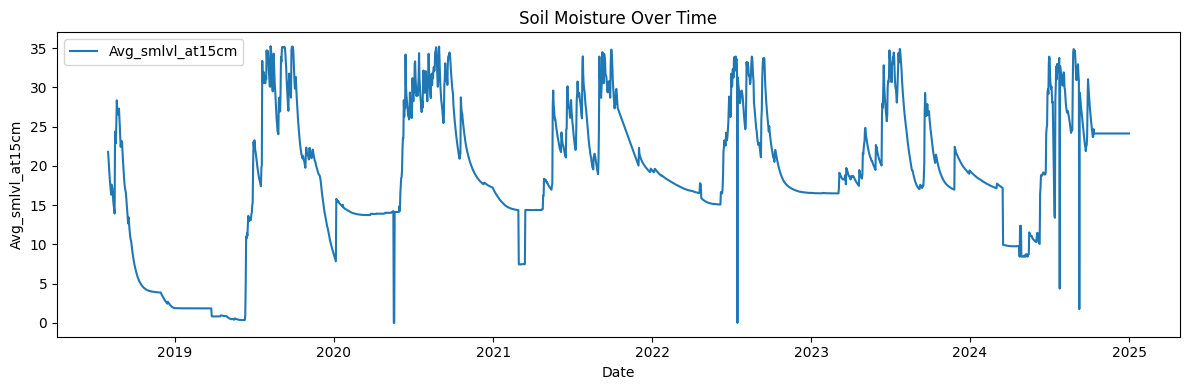

In [9]:
print("Final dataset shape:", scaled_df.shape)

plt.figure(figsize=(12, 4))
plt.plot(scaled_df['datetime'], scaled_df['Avg_smlvl_at15cm'], label='Avg_smlvl_at15cm')
plt.title("Soil Moisture Over Time")
plt.xlabel("Date")
plt.ylabel("Avg_smlvl_at15cm")
plt.legend()
plt.tight_layout()
plt.show()


TILL HERE IS DONEEEEEEEEEEEEE

In [10]:
def create_sequences(data, n_steps=7):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])  # Historical window (e.g., 7 days)
        y.append(data[i+n_steps])    # Next-day soil moisture
    return np.array(X), np.array(y)

# Use scaled features (air_temp, humidity, etc.) as input
n_steps = 7  # 7-day lookback
X, y = create_sequences(scaled_df[['air_temp_scaled', 'air_humidity_scaled', 'soil_moisture_scaled']].values, n_steps)

In [11]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Enhanced LSTM Model Architecture
model = Sequential([
    Input(shape=(n_steps, 3), name='input_layer'),
    LSTM(128, 
         activation='tanh',
         return_sequences=True,
         kernel_regularizer=l2(0.01),
         recurrent_dropout=0.2,
         name='lstm_1'),
    Dropout(0.3, name='dropout_1'),
    LSTM(64,
         activation='tanh',
         return_sequences=False,
         kernel_regularizer=l2(0.005),
         name='lstm_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='linear', name='output')
])

# Optimizer with learning rate scheduling
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.95
    ),
    clipvalue=0.5
)

# Model compilation
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Model summary
model.summary()

I0000 00:00:1744646649.837905      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744646649.838591      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 7, 128)              │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Before splitting, ensure no NaN in target (soil moisture)
print("Original NaN count:", merged_df['Avg_smlvl_at15cm'].isna().sum())

# Fill NaN using forward-fill + interpolation (for time series)
merged_df['Avg_smlvl_at15cm'] = merged_df['Avg_smlvl_at15cm'].interpolate().ffill().bfill()

# Verifymerged_df['Avg_smlvl_at15cm'] = merged_df['Avg_smlvl_at15cm'].interpolate(limit=3).ffill().bfill()
assert not merged_df['Avg_smlvl_at15cm'].isna().any(), "NaNs still exist!"

Original NaN count: 80


In [13]:
# Re-generate X, y with cleaned data
X, y = create_sequences(
    scaled_df[['air_temp_scaled', 'air_humidity_scaled', 'soil_moisture_scaled']].values,
    n_steps=7
)
print(f"X shape: {X.shape}, y shape: {y.shape}")
# Verify no NaN in y
print("NaN in y:", np.isnan(y).any())

X shape: (2338, 7, 3), y shape: (2338, 3)
NaN in y: True


In [14]:
# Split ensuring no NaN in test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=False  # Critical for time series
)
print(f"Train dates: {X_train.shape[0]} samples\nTest dates: {X_test.shape[0]} samples")
# Final check
print("NaN in y_test:", np.isnan(y_test).any())

Train dates: 1636 samples
Test dates: 702 samples
NaN in y_test: True


In [15]:
# Force-clean the test set if needed
valid_mask = ~np.isnan(y_test).any(axis=1)
X_test = X_test[valid_mask]
y_test = y_test[valid_mask]
dropped = len(valid_mask) - sum(valid_mask)
print(f"Dropped {dropped} invalid test samples")  

Dropped 80 invalid test samples


In [16]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"NaN in training: {np.isnan(X_train).sum()}, {np.isnan(y_train).sum()}")
print(f"NaN in testing: {np.isnan(X_test).sum()}, {np.isnan(y_test).sum()}")
print(f"Train moisture range: {y_train.min():.2f} to {y_train.max():.2f}")  
print(f"Test moisture range: {y_test.min():.2f} to {y_test.max():.2f}")  

X_train shape: (1636, 7, 3), y_train shape: (1636, 3)
NaN in training: 0, 0
NaN in testing: 0, 0
Train moisture range: 0.00 to 1.00
Test moisture range: 0.00 to 0.99


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Initialize optimizer with reasonable defaults
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # Good starting point for LSTMs
    clipvalue=0.5        # Gradient clipping
)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

# Training configuration
history = model.fit(
    X_train, y_train,
    epochs=50,  # Reduced from 200 based on your observation
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True),  # More aggressive early stopping
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),  # Faster LR reduction
        ModelCheckpoint('best_model.keras', save_best_only=True),
        TensorBoard(log_dir='./logs')
    ],
    verbose=1
)

Epoch 1/50


I0000 00:00:1744646657.175902      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.8479 - mae: 0.2648 - mse: 0.1193 - val_loss: 0.3306 - val_mae: 0.1220 - val_mse: 0.0231 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2710 - mae: 0.1412 - mse: 0.0307 - val_loss: 0.1301 - val_mae: 0.1207 - val_mse: 0.0225 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1178 - mae: 0.1383 - mse: 0.0298 - val_loss: 0.0710 - val_mae: 0.1215 - val_mse: 0.0229 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0717 - mae: 0.1398 - mse: 0.0301 - val_loss: 0.0499 - val_mae: 0.1222 - val_mse: 0.0231 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0535 - mae: 0.1392 - mse: 0.0295 - val_loss: 0.0392 - val_mae: 0.1207 - val_mse: 0.0224 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0434 - mae: 0.1364 - mse: 0.0282 - val_loss: 0.0335 - val_mae: 0.1207 - val_mse: 0.02

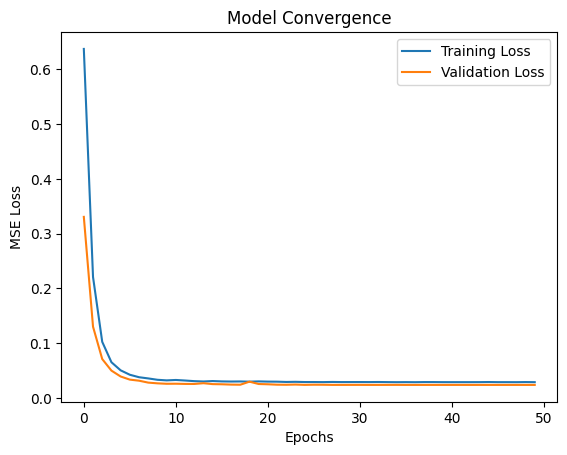

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [19]:
# Sample prediction
test_sample = X_test[0:1]  # First test sample
prediction = model.predict(test_sample)[0][0]

# Create dummy array with ALL original features (fill others with 0)
dummy_array = np.zeros((1, 4))  # 4 features total
dummy_array[0, 2] = prediction  # Assuming soil_moisture is 3rd column (0-indexed)

# Convert back to original scale
pred_original = scaler.inverse_transform(dummy_array)[0, 2]  # Get 3rd column

print(f"Predicted moisture: {pred_original:.2f} (Original scale)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Predicted moisture: 52.57 (Original scale)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.1017
RMSE: 0.1312


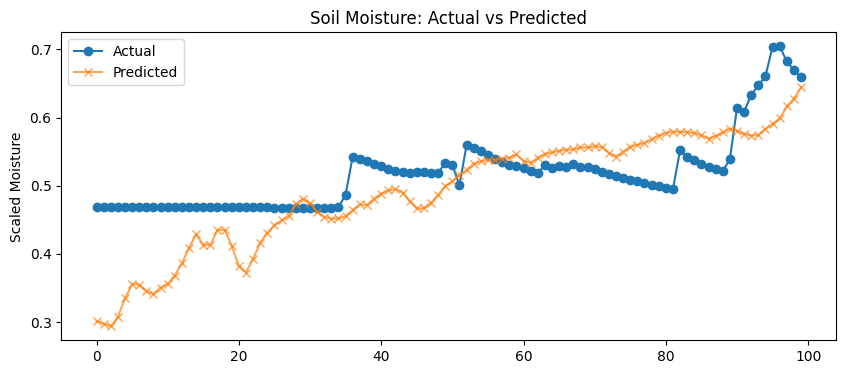


Shapes - y_test_moisture: (622,), y_pred: (622,)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Extract ONLY soil moisture from y_test (assuming last column)
y_test_moisture = y_test[:, -1]  # Use correct column index if different

# 2. Get predictions and flatten
y_pred = model.predict(X_test).flatten()

# 3. Calculate metrics
mae = mean_absolute_error(y_test_moisture, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_moisture, y_pred))
print(f"MAE: {mae:.4f}\nRMSE: {rmse:.4f}")

# 4. Visual comparison
plt.figure(figsize=(10,4))
plt.plot(y_test_moisture[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', alpha=0.7, marker='x')
plt.title("Soil Moisture: Actual vs Predicted")
plt.ylabel("Scaled Moisture")
plt.legend()
plt.show()

# Shape verification
print(f"\nShapes - y_test_moisture: {y_test_moisture.shape}, y_pred: {y_pred.shape}")

In [21]:
import joblib  # Add this import at the top of your notebook
from tensorflow.keras.models import load_model

# 1. Save model and scaler
model.save('final_soil_moisture_model.keras')
joblib.dump(scaler, 'soil_scaler.save')

# 2. Verify saving worked
try:
    test_model = load_model('final_soil_moisture_model.keras')
    test_scaler = joblib.load('soil_scaler.save')
    print("✅ Model and scaler saved successfully!")
except Exception as e:
    print(f"Error loading saved files: {e}")

✅ Model and scaler saved successfully!


In [22]:
def predict_moisture(temp, humidity, rainfall):
    # Scale inputs (add dummy moisture)
    scaled = scaler.transform([[temp, humidity, rainfall, 0]])[0][:3]  
    prediction = model.predict(np.array([scaled]))[0][0]
    return scaler.inverse_transform([[0, 0, 0, prediction]])[0][3]

In [23]:
def predict_moisture(temp, humidity, rainfall):
    """Proper prediction with feature names handling"""
    # Create DataFrame with original feature names
    input_df = pd.DataFrame([[temp, humidity, rainfall, 0]], 
                          columns=['air_temp', 'air_humidity', 'rainfall', 'soil_moisture'])
    
    # Scale
    scaled = scaler.transform(input_df)[0, :3]  # Get first 3 scaled features
    
    # Reshape for LSTM
    prediction_input = scaled.reshape(1, 1, 3)
    
    # Predict and inverse scale
    prediction = model.predict(prediction_input)[0][0]
    dummy_output = np.array([[0, 0, 0, prediction]])
    return scaler.inverse_transform(dummy_output)[0][3]

In [24]:
print(f"Final Metrics - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Final Metrics - MAE: 0.1017, RMSE: 0.1312
